# 11.2 License plate location

License plate location is an important stage in vehicle license plate recognition for automated transport system. It's responsible for finding and isolating the plate on the picture:

<img src="./images/location.png" width="850" />

In this practise you will develop a basic plate detector, which will be able to detect and segment a car plate in a photo. You will need to understand how edge detection (chapter 03), region description (chapter 06) and homographies (chapter 08) work in order to complete this notebook.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (16.0, 16.0)
images_path = './images/'

### <span style="color:green"><b><i>ASSIGNMENT 1: Developing our own car plate detector</i></b></span>

Our task in this notebook is constructing a car plate detector that have to be able to detect and segment appearing plates in images. Next, the main steps of a plate detector are commented briefly, but all of them have been previously implemented in other notebooks. 

# Steps for detecting a plate

We can reduce this problem to a set of subproblems that we actually solved in previous notebooks:

**Detecting the edges of the image**

We can use Canny, LoG, Sobel, ... to obtain an edge image that will be needed for studying the shapes.

**Finding contours in edge image**

Our objective in to find the biggest polygon with 4 corners (rectangle in perspective) in the image, that will be our main candidate to be the actual plate. For this, you will have to **find the contours** in the edge image, and then **sort them by its area**.

**Obtaining the coordinates of the plate**

Now that we have a sorted list of the biggest contours in the image, we have iterate it checking if their approximate polygon (this can be found using [cv2.approxPolyDP](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga0012a5fdaea70b8a9970165d98722b4c)) have 4 corners, the plate will usually be that polygon.

**(Optional) Improve the corners detection**

We can find the sub-pixel accurate location of plate corners, improving the accuracy of the location of the corners. This can be done using [cv2.cornerSubPix](https://docs.opencv.org/4.2.0/dd/d1a/group__imgproc__feature.html#ga354e0d7c86d0d9da75de9b9701a9a87e).

**Removing the perspective of the plate**

We usually want the plate image without perspective distortion, as they will be used for character recognition. For this, you just need to apply an homograpy, obtaining the final image.

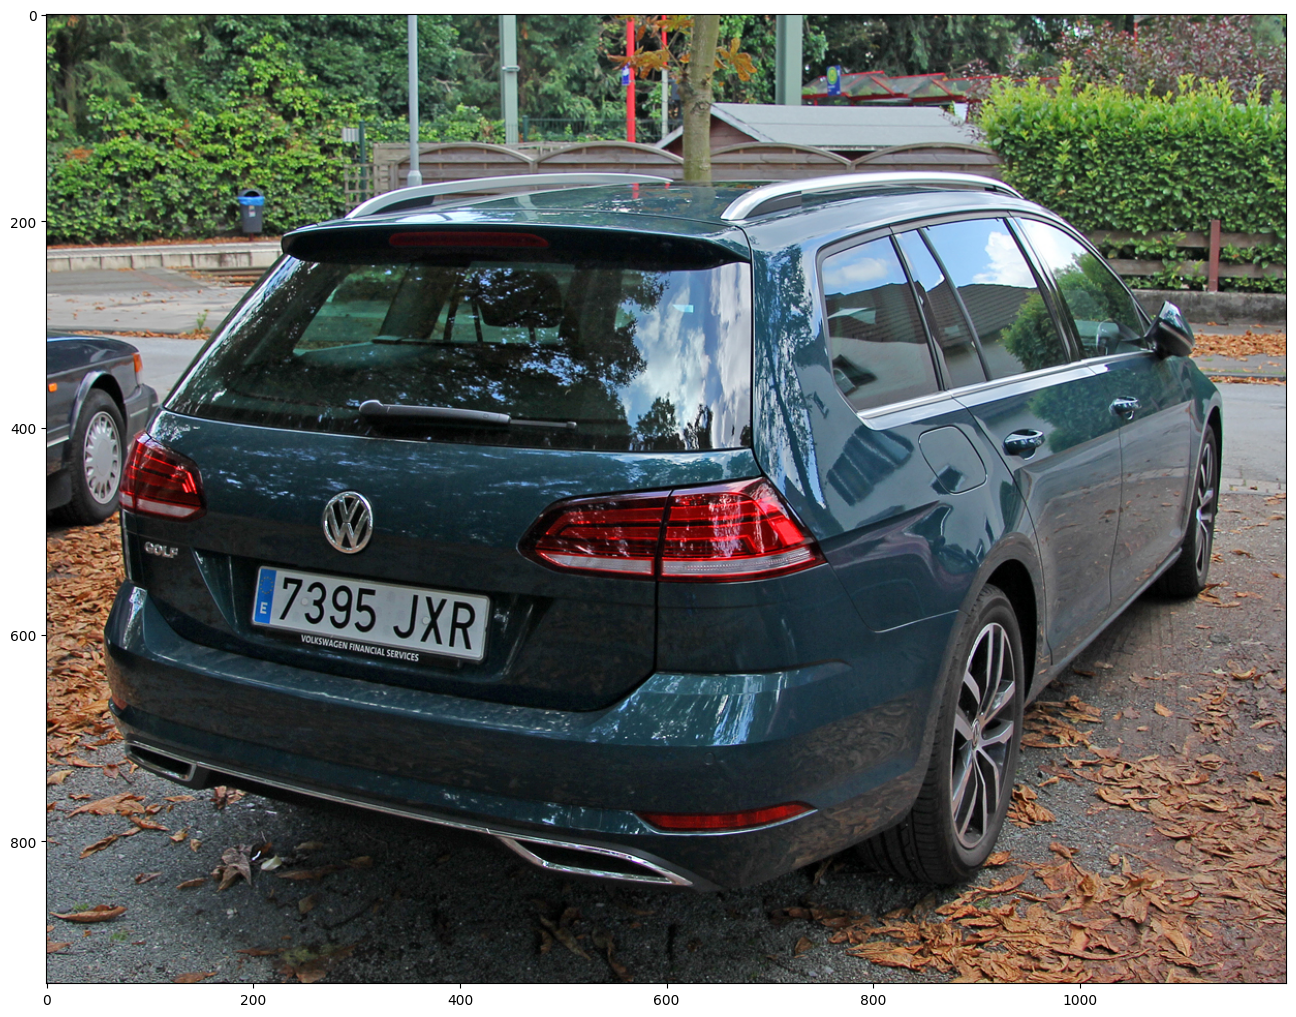

In [2]:
# Read image
image = cv2.imread(images_path + 'car_plate.jpg')
# Convert it to RGB and grayscale
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Apply Gaussian filter
gray = cv2.GaussianBlur(gray, (5,5), 1.4, 1.4)
# Show it
plt.imshow(image)

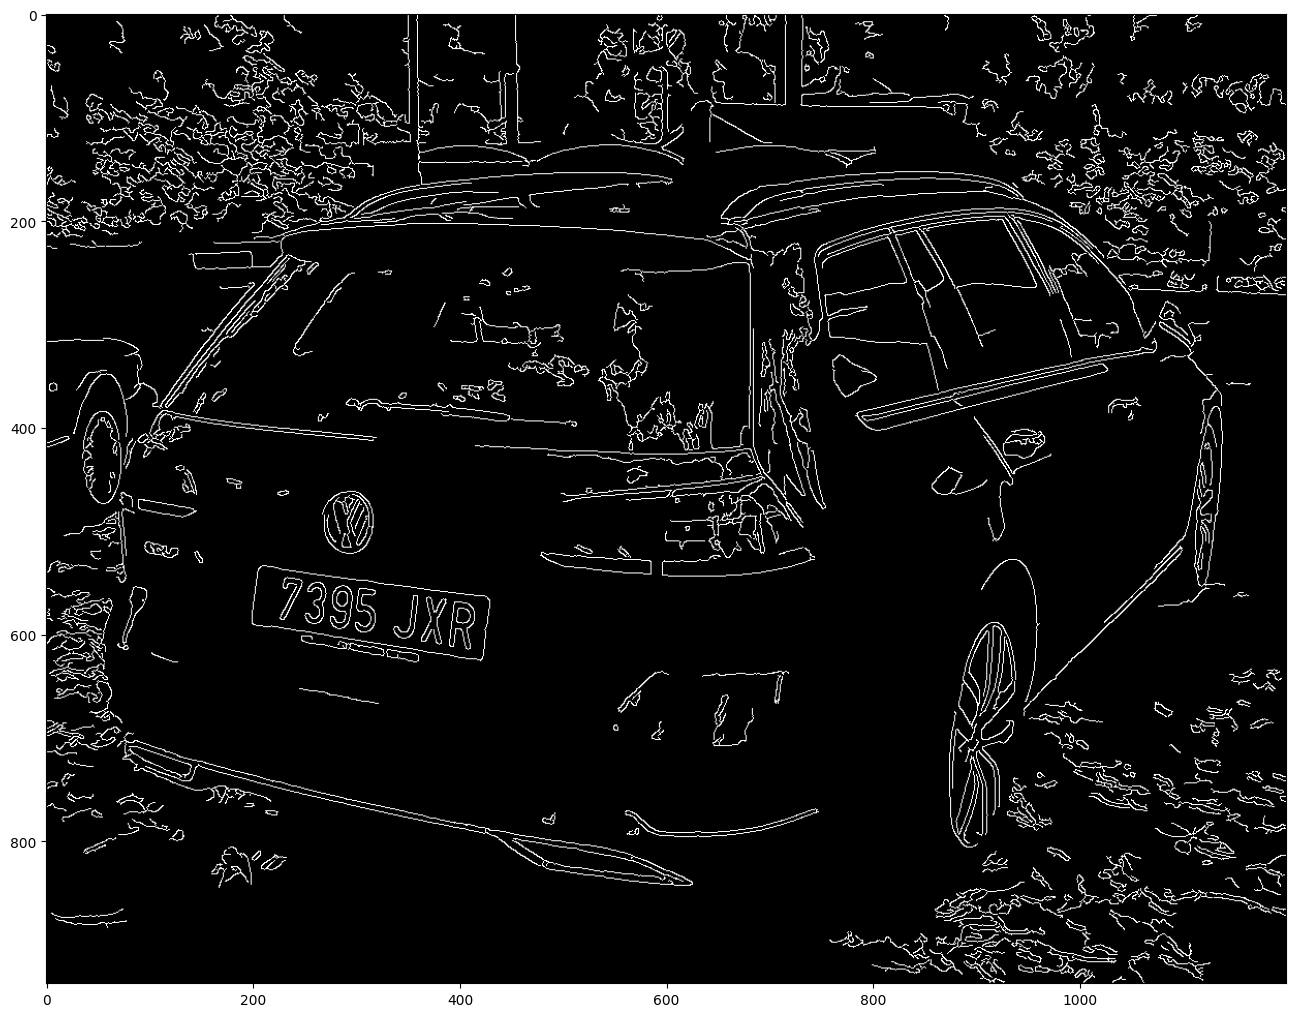

In [3]:
# Apply Canny edge detector
edged = cv2.Canny(gray, 255/3, 255)
# Show results
plt.imshow(edged, cmap="gray")

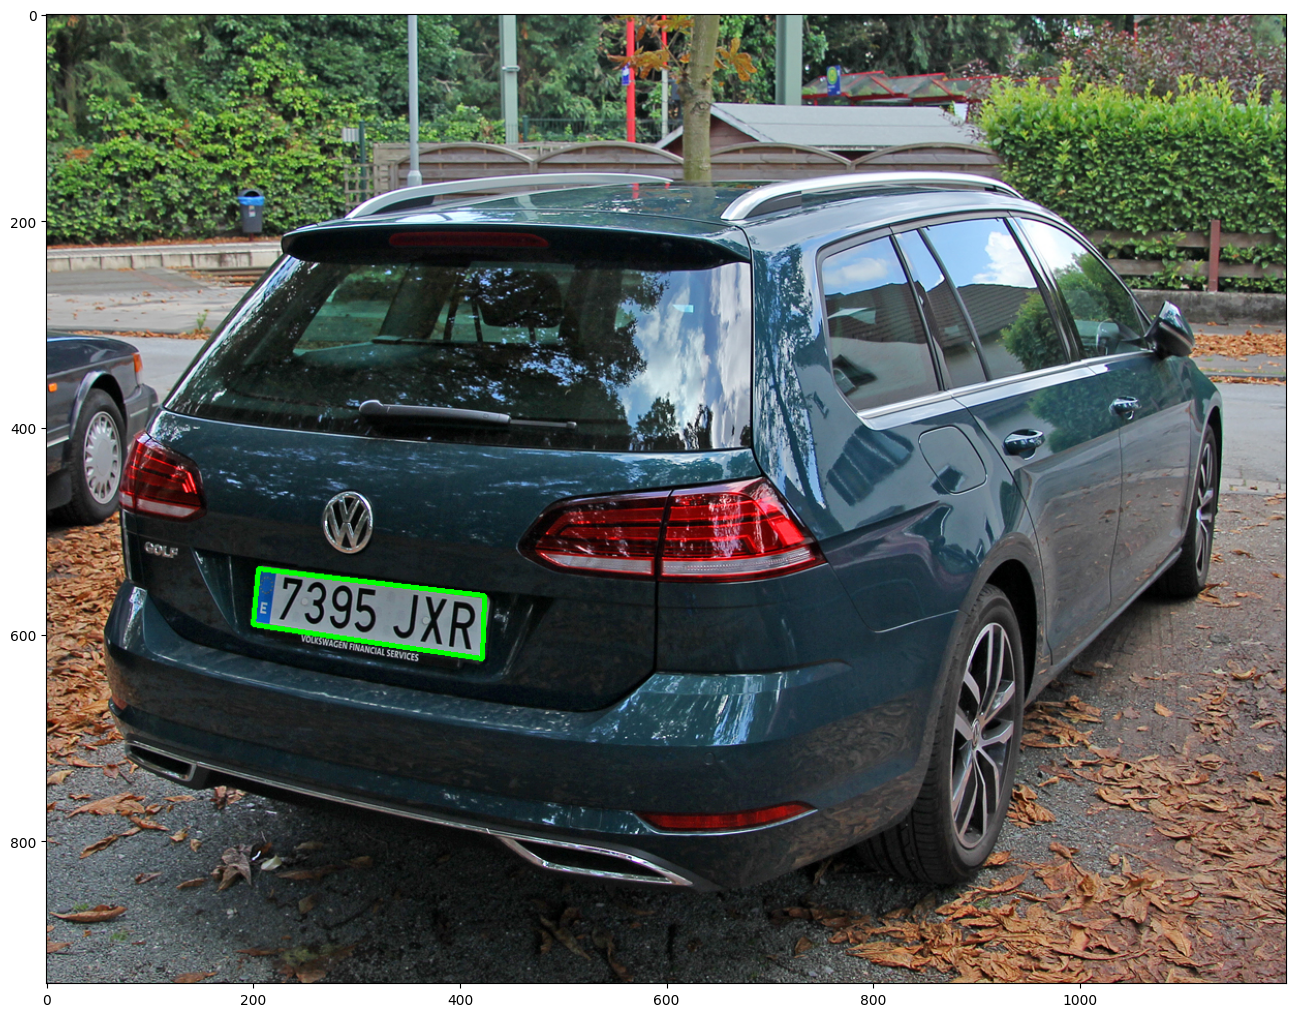

In [4]:
# Find contours in edge image
(cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

# Sort contours by area
cnts=sorted(cnts, key = cv2.contourArea, reverse = True)
NumberPlateCnt = None

# For each contour
for c in cnts:
    # Approximate polygons from shapes
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.03 * peri, True)
    # Check if it is a rectangle
    if len(approx) == 4: 
        NumberPlateCnt = approx
        # Keep the biggest (first) rectangle
        break
        
# Draw selected contour
res_image = image.copy()
cv2.drawContours(res_image, [NumberPlateCnt], -1, (0,255,0), 3)
# Show results
plt.imshow(res_image)

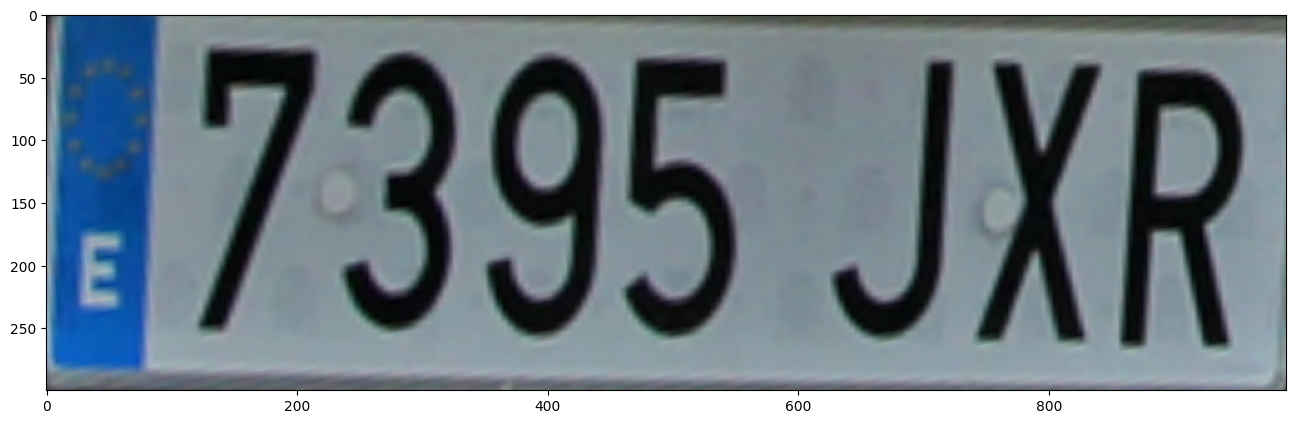

In [5]:
pts_src = np.float32(NumberPlateCnt).reshape(4,2)

pts_dst = np.array([[0, 0], [0, 100], [330, 100],[330, 0]])*3

# Calculate Homography
M, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
no_perspective = cv2.warpPerspective(image, M, (990,300))

# Show image without perspective
plt.imshow(no_perspective)

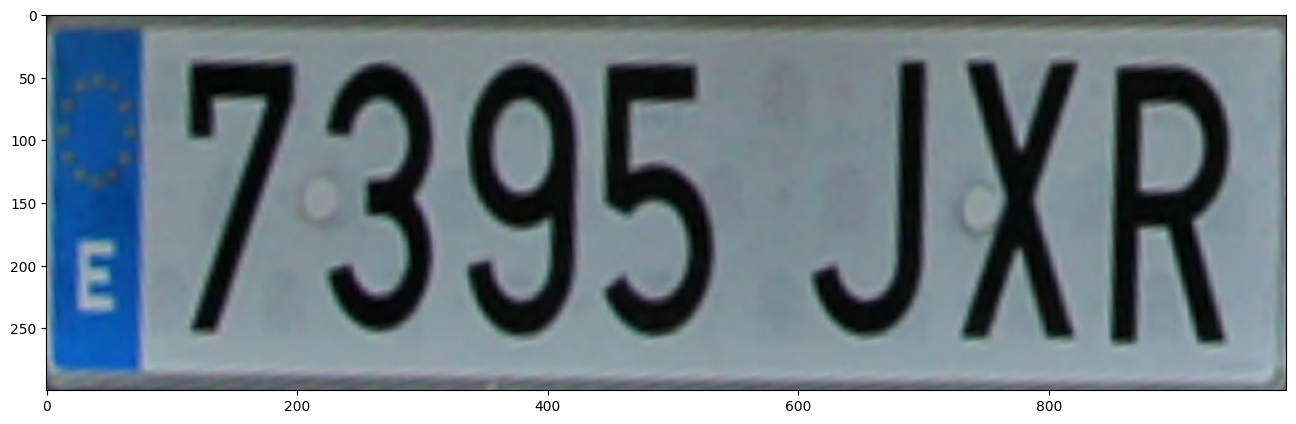

In [6]:
# Find the sub-pixel accurate location of plate corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
pts_src = cv2.cornerSubPix(gray,pts_src,(5,5),(-1,-1),criteria)

# Calculate Homography
M, status = cv2.findHomography(pts_src, pts_dst)

# Warp source image to destination based on homography
no_perspective = cv2.warpPerspective(image, M, (990,300))

# Show image without perspective
plt.imshow(no_perspective)